# Generate pre-labeled kymographs for testing VAE
#### Capstone Group L

Provides an interface for generating sample artificial kymographs and generating datasets of arbitrariy size, characteristics for training and validating VAE models.

In [57]:
#Required Packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from scipy import stats
from scipy.ndimage import convolve
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import json
from json import JSONEncoder
import bson
import os

In [46]:
#common variables
pi = np.pi

##  Interactive data widget

In [47]:
@interact_manual

def KymogenInteractive(style=["sin","polar","random", "osc_rand"], height=(20, 200, 10), width=(60, 300, 20)):

    """Generates an artificial kymograph of given shape and dimensions. """
    
    h,w = height, width
    hscale = (h/100)
    wscale = (w/200)

    def sinkymo():
        #Base assignments
        domain = np.linspace(0,6*np.pi,w)
        phase = (np.random.rand(1)*pi)
        freq = (np.random.rand(1))
        heatmap = np.random.normal(1,0.4,(h,w))
        #heatmap = np.ones((h,w))

        #callables
        shiftsin = lambda t,phase,freq : 35*hscale*(np.sin(freq*t+phase))+50*hscale #base sin wave

        #mid assigns
        mapRange = np.array(shiftsin(domain,phase, freq))
        normRange = (np.floor(mapRange))

        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(int(-9*hscale),int(10*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
            else:
                for k in range(int(-3*hscale),int(4*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))

        #plot smoothing
        kernel_size = int(8*((hscale+wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        
        return heatmap

    def doublesinkymo():
        #Base assignments
        domain = np.linspace(0,6*np.pi,w)
        phase = (np.random.rand(1)*pi)
        freq = (np.random.rand(1))
        heatmap = np.random.normal(1.5,1,(h,w))

        #callables
        shiftsin = lambda t,phase,freq : 35*hscale*(np.sin(freq*t+phase))+50*hscale #base sin wave

        #mid assigns
        mapRange = np.array(shiftsin(domain,phase, freq))
        normRange = (np.floor(mapRange))

        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(int(-9*hscale),int(10*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
                    heatmap[-(int(normRange[i])+k),-i] = 1+random.uniform(0, 1.1)-0.02*(i/(10*wscale))
            else:
                for k in range(int(-3*hscale),int(4*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))
                    heatmap[-(int(normRange[i])+k),-i] = 1+random.uniform(0.5, 2)-0.02*(i/(10*wscale))

        #plot smoothing
        kernel_size = int(8*((hscale+wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        
        return heatmap
    
#TODO -- Scale factors for polkymo, randkymo

    def polkymo():
        domain = np.linspace(0,6*np.pi,w)
        heatmap = np.random.normal(1,0.6,(h,w))
        
        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(0,int(10*hscale)):
                    heatmap[h-(k+1),i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
            else:
                for k in range(0,int(4*hscale)):
                    heatmap[h-(k+1),i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))
                    
        #plot smoothing
        kernel_size = int(8*((hscale*wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
      
        return heatmap
            
    def randkymo():
        domain = np.linspace(0,6*np.pi,w)
        heatmap = np.random.normal(3,1.6,(h,w))
        kernel_size = int(8*((hscale*wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        return heatmap
        
            
    if style == "sin":
        kymo = plt.imshow(sinkymo(), cmap='plasma', interpolation='nearest')
    elif style == "polar":
        kymo = plt.imshow(polkymo(), cmap='plasma', interpolation='nearest')
    elif style == "random":
        kymo = plt.imshow(randkymo(), cmap='plasma', interpolation='nearest')
    elif style == "osc_rand":
        kymo = plt.imshow(doublesinkymo(), cmap='plasma', interpolation='nearest')
    else:
        raise ValueError("'style' must be set to string 'sin', 'polar', or 'random'.")
    
    plt.title("PlzC Kymograph Artificial Data - {}".format(style))
    plt.xlabel("Time (ms/2)")
    plt.ylabel("Axis Position")
    

interactive(children=(Dropdown(description='style', options=('sin', 'polar', 'random', 'osc_rand'), value='sin…

#### Dataset Generator Functions

In [48]:
def KymogenGenerative(style=["sin","polar","random"], height=(100, 1000, 50), width=(100, 1000, 50)):
    """Generates a matrix defining artifical kymograph. """
    
    h,w = height, width
    hscale = (h/100)
    wscale = (w/200)

    def sinkymo():
        #Base assignments
        domain = np.linspace(0,6*np.pi,w)
        phase = (np.random.rand(1)*pi)
        freq = (np.random.rand(1))
        heatmap = np.random.normal(1,0.4,(h,w))
        #heatmap = np.ones((h,w))

        #callables
        shiftsin = lambda t,phase,freq : 35*hscale*(np.sin(freq*t+phase))+50*hscale #base sin wave

        #mid assigns
        mapRange = np.array(shiftsin(domain,phase, freq))
        normRange = (np.floor(mapRange))

        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(int(-9*hscale),int(10*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
            else:
                for k in range(int(-3*hscale),int(4*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))

        #plot smoothing
        kernel_size = int(8*((hscale+wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        
        return heatmap

    def doublesinkymo():
        #Base assignments
        domain = np.linspace(0,6*np.pi,w)
        phase = (np.random.rand(1)*pi)
        freq = (np.random.rand(1))
        heatmap = np.random.normal(1.5,1,(h,w))

        #callables
        shiftsin = lambda t,phase,freq : 35*hscale*(np.sin(freq*t+phase))+50*hscale #base sin wave

        #mid assigns
        mapRange = np.array(shiftsin(domain,phase, freq))
        normRange = (np.floor(mapRange))

        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(int(-9*hscale),int(10*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
                    heatmap[-(int(normRange[i])+k),-i] = 1+random.uniform(0, 1.1)-0.02*(i/(10*wscale))
            else:
                for k in range(int(-3*hscale),int(4*hscale)):
                    heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))
                    heatmap[-(int(normRange[i])+k),-i] = 1+random.uniform(0.5, 2)-0.02*(i/(10*wscale))

        #plot smoothing
        kernel_size = int(8*((hscale+wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        
        return heatmap

    def polkymo():
        domain = np.linspace(0,6*np.pi,w)
        heatmap = np.random.normal(1,0.6,(h,w))
        
        for i in range(0,w):
            if bool(random.getrandbits(1)):
                for k in range(0,int(10*hscale)):
                    heatmap[h-(k+1),i] = 1+random.uniform(1, 2)-0.02*(i/(10*wscale))
            else:
                for k in range(0,int(4*hscale)):
                    heatmap[h-(k+1),i] = 1+random.uniform(0.5, 3)-0.03*(i/(10*wscale))
                    
        #plot smoothing
        kernel_size = int(8*((hscale*wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
      
        return heatmap
            
    def randkymo():
        domain = np.linspace(0,6*np.pi,w)
        heatmap = np.random.normal(3,1.6,(h,w))
        kernel_size = int(8*((hscale*wscale)/2))+2
        kernel = np.ones((kernel_size,kernel_size))/ kernel_size
        heatmap = convolve(heatmap, kernel)
        heatmap = convolve(heatmap, kernel)
        return heatmap
        
            
    if style == "sin":
        return sinkymo()
    elif style == "polar":
        return polkymo()
    elif style == "random":
        return randkymo()
    else:
        raise ValueError("'style' must be set to string 'sin', 'polar', or 'random'.")

In [49]:
def sampleGenerator(n, h, w, forms = ['sin','polar','random']):

    """Generates artificial dataset with n size hxw kymographs of each form specified"""

    sampleSize = [n,len(forms),h,w]
    sample = np.zeros(sampleSize)

    for i in range(len(forms)): #0:2
        for j in range(n):
            sample[j,i] = KymogenGenerative(style = forms[i], height=h, width=w)

    return sample

#### Encoder

Although data from DotsWorkflow is BSON I couldn't figure out how to make a BSON encoder so just used JSON. Some examples of how to label, encode, and decode the dataset are shown. Note that the IDs of the kymographs are the first two dimensions of the array, while the kymograph itself occupies the remaining dimensions.

In [50]:
#Custom JSON encoder for numpy tensors
class NumpyTensor(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [51]:
#Custom BSON encoder for numpy tensors

class NumpyTensorBSON:
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return bson.binary.Binary(obj.tobytes(), **self.kwargs)
        return obj

def bson_numpy_dumps(obj):
    return bson.dumps(obj, default=NumpyTensorBSON().default)

def bson_numpy_loads(bson_data):
    return bson.loads(bson_data)

In [52]:
#Example encoding process (JSON)
kymoset = sampleGenerator(50,20,60,forms=['sin','polar','random'])
kymoset_data = {"kymoset": kymoset}
kymoset_JSON = json.dumps(kymoset_data, cls=NumpyTensor)

In [53]:
#Example encoding process (BSON)

def custom_encoder(data):
    if isinstance(data, dict):
        new_dict = {}
        for key, value in data.items():
            if isinstance(value, np.ndarray):
                new_dict[key] = value.tolist()
            else:
                new_dict[key] = value
        return new_dict
    return data

#Example encoding process (BSON)
kymoset = sampleGenerator(50,20,60,forms=['sin','polar','random'])
kymoset_data = {"kymoset": kymoset}
kymoset_data_encoded = custom_encoder(kymoset_data)
kymoset_BSON = bson.dumps(kymoset_data_encoded)




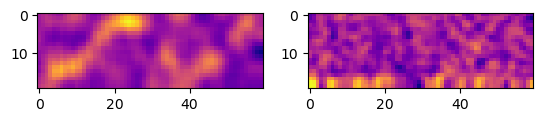

In [54]:
#Example decoding process (probably not necessary with pytorch dataloader) and demo of storage indicies
decoded_kymo = np.asarray(json.loads(kymoset_JSON)["kymoset"])
plt.subplot(1,2,1)
plt.imshow(decoded_kymo[0,0,:,:], cmap='plasma', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(decoded_kymo[2,1,:,:], cmap='plasma', interpolation='nearest')

In [58]:
file_path = 'C:/Users/Jacob/Documents/Winter_2023/BE177B/Code/data/kymoset.json'
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
datafolder = 'C:/Users/Jacob/Documents/Winter_2023/BE177B/Code/data'
with open(datafolder+'/kymoset.json', 'w') as f:
  bson.dump(kymoset_data, f, ensure_ascii=False, cls=NumpyTensor)

In [55]:
#Example dump to a file in local system
datafolder = 'C:/Users/Jacob/Documents/Winter_2023/BE177B/Code/data'
with open(datafolder+'/kymoset.json', 'w') as f:
  json.dump(kymoset_data, f, ensure_ascii=False, cls=NumpyTensor)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/data/kymoset.json'

In [ ]:
# @interact_manual

# def Kymogen(style=["sin","polar","random"]):
#     """Generates a kymograph with specified shape, more tunable parameters tbd"""
    
#     def sinkymo():
#         #Base assignments
#         domain = np.linspace(0,6*np.pi,200)
#         phase = (np.random.rand(1)*pi)
#         freq = (np.random.rand(1))
#         heatmap = np.random.normal(1.5,1,(100,200))

#         #callables
#         shiftsin = lambda t,phase,freq : 35*(np.sin(freq*t+phase))+50 #base sin wave

#         #mid assigns
#         mapRange = np.array(shiftsin(domain,phase, freq))
#         normRange = (np.floor(mapRange))

#         for i in range(0,200):
#             if bool(random.getrandbits(1)):
#                 for k in range(-9,10):
#                     heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/10)
#             else:
#                 for k in range(-3,4):
#                     heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/10)

#         #plot smoothing
#         kernel_size = 12
#         kernel = np.ones((kernel_size,kernel_size))/ kernel_size
#         heatmap = convolve(heatmap, kernel)
#         heatmap = convolve(heatmap, kernel)
        
#         return heatmap
        
#     def polkymo():
#         domain = np.linspace(0,6*np.pi,200)
#         heatmap = np.random.normal(1.5,0.8,(100,200))
        
#         for i in range(0,200):
#             if bool(random.getrandbits(1)):
#                 for k in range(0,10):
#                     heatmap[99-k,i] = 1+random.uniform(1, 2)-0.02*(i/10)
#             else:
#                 for k in range(0,4):
#                     heatmap[99-k,i] = 1+random.uniform(0.5, 3)-0.03*(i/10)
                    
#         #plot smoothing
#         kernel_size = 8
#         kernel = np.ones((kernel_size,kernel_size))/ kernel_size
#         heatmap = convolve(heatmap, kernel)
#         heatmap = convolve(heatmap, kernel)
      
#         return heatmap
            
#     def randkymo():
#         domain = np.linspace(0,6*np.pi,200)
#         heatmap = np.random.normal(3,1.6,(100,200))
#         kernel_size = 12
#         kernel = np.ones((kernel_size,kernel_size))/ kernel_size
#         heatmap = convolve(heatmap, kernel)
#         heatmap = convolve(heatmap, kernel)
#         return heatmap
        
            
#     if style == "sin":
#         plt.imshow(sinkymo(), cmap='plasma', interpolation='nearest')
#         plt.show() 
#     elif style == "polar":
#         plt.imshow(polkymo(), cmap='plasma', interpolation='nearest')
#         plt.show()
#     elif style == "random":
#         plt.imshow(randkymo(), cmap='plasma', interpolation='nearest')
#         plt.show()
#     else:
#         raise ValueError("'style' must be set to string 'sin', 'polar', or 'random'.")

In [ ]:
# # -------------OLD TEST------------------
# #Base assignments
# domain = np.linspace(0,6*np.pi,200)
# phase = (np.random.rand(1)*pi)
# freq = (np.random.rand(1))
# heatmap = np.random.normal(1.5,1,(100,200))

# #callables
# shiftsin = lambda t,phase,freq : 35*(np.sin(freq*t+phase))+50 #base sin wave

# #mid assigns
# mapRange = np.array(shiftsin(domain,phase, freq))
# normRange = (np.floor(mapRange))

# for i in range(0,200):
#     if bool(random.getrandbits(1)):
#         for k in range(-9,10):
#             heatmap[int(normRange[i])+k,i] = 1+random.uniform(1, 2)-0.02*(i/10)
#     else:
#         for k in range(-3,4):
#             heatmap[int(normRange[i])+k,i] = 1+random.uniform(0.5, 3)-0.03*(i/10)

# #plot smoothing
# kernel_size = 12
# kernel = np.ones((kernel_size,kernel_size))/ kernel_size
# heatmap = convolve(heatmap, kernel)
# heatmap = convolve(heatmap, kernel)
    

# plt.imshow(heatmap, cmap='plasma', interpolation='nearest')
# plt.show() 